In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
import numpy as np

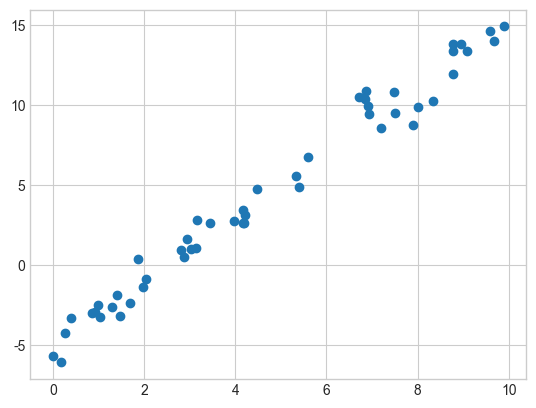

In [61]:
# 生成一份大致分布在斜率2 截距-5 的線上的資料
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

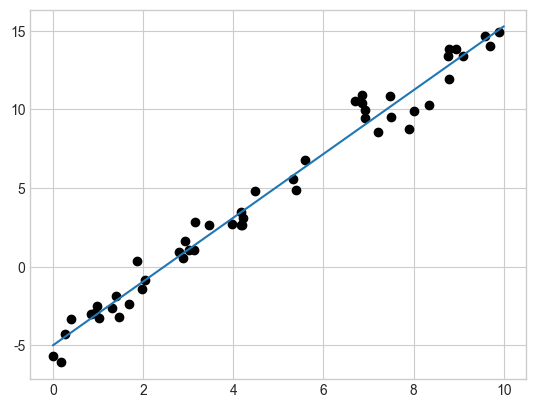

In [62]:
# 擬合一條直線
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit= model.predict(xfit[:, np.newaxis])

plt.scatter(x, y, color='black')
plt.plot(xfit, yfit);


In [63]:
# 查看模型計算出的參數
print("Model slope: ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:  2.0272088103606944
Model intercept: -4.9985770855532


In [64]:
# 擬合高維度資料
rng = np.random.RandomState(1)
X = 10 * rng.rand(100,3)
y = 0.5 + np.dot(X, [1.5, -1., 1.])

model.fit(X,y)
print(model.intercept_)
print(model.coef_)

0.5000000000000062
[ 1.5 -1.   1. ]


In [65]:
# 多項式映射
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

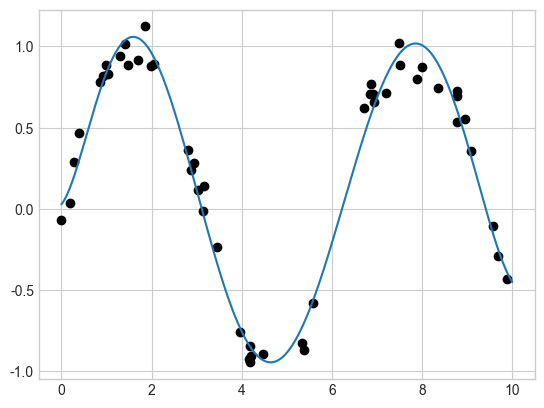

In [66]:
# 利用pipeline 建立 7 階多項式模型
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

# 擬合更複雜的x y 關係 例如具備雜訊的正弦函數波型
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y, color='black')
plt.plot(xfit, yfit);

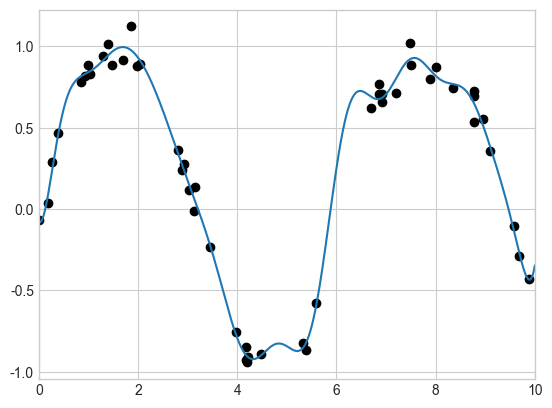

In [67]:
# 自建高斯基函數
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""

    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor

    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
    
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor*(self.centers_[1]-self.centers_[0])
        return self
    
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)
    
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y, color='black')
plt.plot(xfit, yfit)
plt.xlim(0, 10);

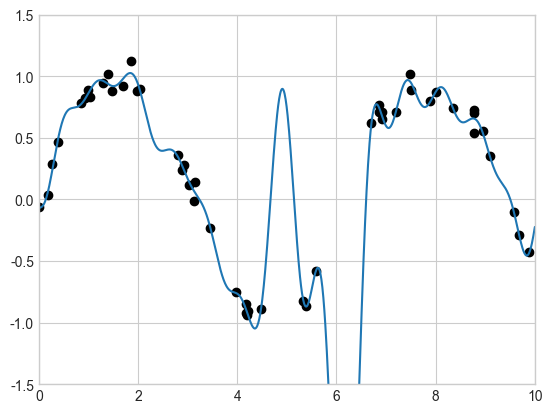

In [68]:
# 引用太多高斯基函數的情況
model = make_pipeline(GaussianFeatures(30),
                      LinearRegression())
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y, color='black')
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);

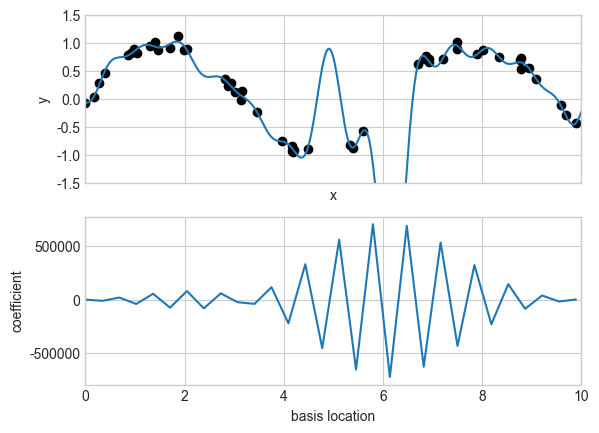

In [69]:
# 畫出高斯係數與相對應的位置
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y, color='black')
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)

    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))
    
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

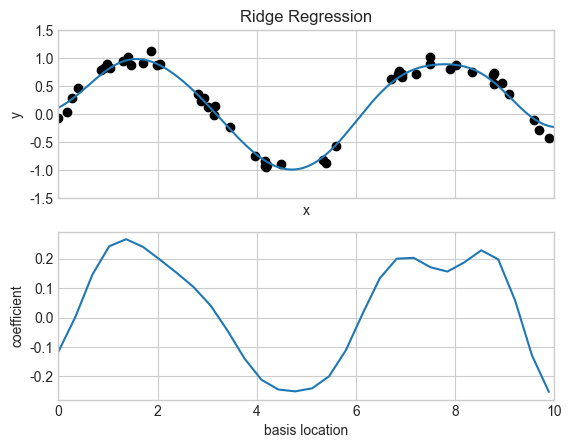

In [70]:
# ridge regression
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=1))
basis_plot(model, title='Ridge Regression')

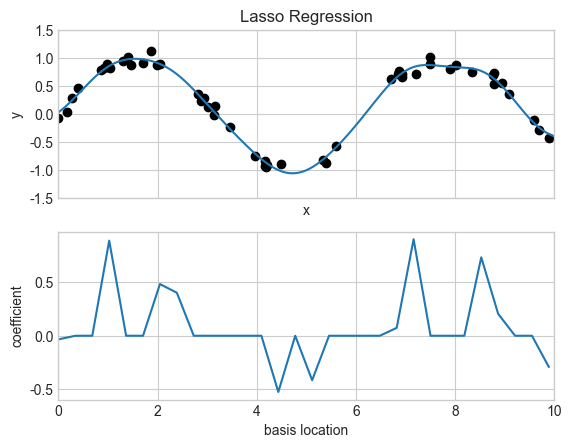

In [71]:
# lasso regression
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001, max_iter=2000))
basis_plot(model, title='Lasso Regression')

In [72]:
# 載入西雅圖自行車與天氣資料集
import pandas as pd
counts = pd.read_csv('../Pandas/data/FremontBridge.csv',
                     index_col='Date', parse_dates=True)
weather = pd.read_csv('../Pandas/data/BicycleWeather.csv',
                     index_col='DATE', parse_dates=True)

C:\Users\coffi\AppData\Local\Temp\ipykernel_11552\3552849396.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  counts = pd.read_csv('../Pandas/data/FremontBridge.csv',


(8.0, 17.0)

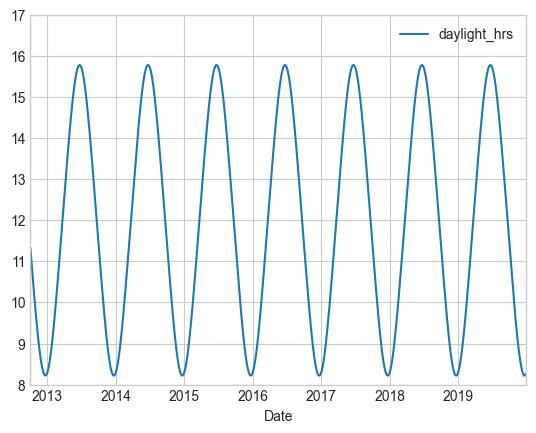

In [73]:
# 只看疫情前的資料
counts = counts[counts.index < "2020-01-01"]
weather = weather[weather.index < "2020-01-01"]

# 計算每天的自行車總流量
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']]

# 建立表示星期的欄位
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

# 把假期標記出來
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'] = daily['holiday'].fillna(0)

# 計算白晝的時數
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.to_datetime('2000-12-21')).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

In [74]:
# 加上溫度與降雨量資訊
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

# 將上年度的計數器
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [75]:
pd.set_option('display.max_columns', None)
print(daily.head())

             Total  Mon  Tue  Wed  Thu  Fri  Sat  Sun  holiday  daylight_hrs  PRCP  Temp (C)  dry day    annual
Date                                                                                                           
2012-10-02  3876.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0      0.0     11.335681   0.0     13.90      1.0  0.000000
2012-10-03  7042.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0      0.0     11.277359   0.0     13.35      1.0  0.002740
2012-10-04  6950.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0      0.0     11.219142   0.0     13.60      1.0  0.005479
2012-10-05  6296.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0      0.0     11.161038   0.0     15.30      1.0  0.008219
2012-10-06  4012.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0      0.0     11.103056   0.0     15.85      1.0  0.010959


<Axes: xlabel='Date'>

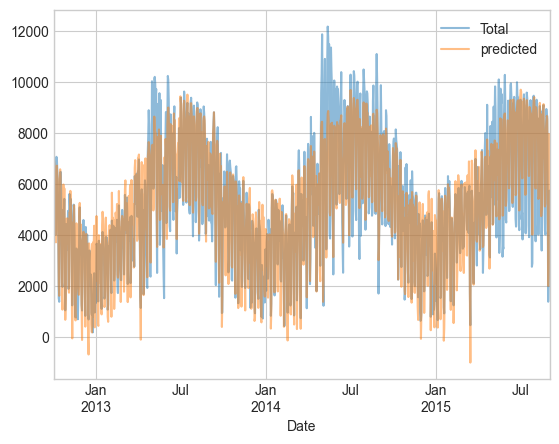

In [80]:
import matplotlib.pyplot as plt
import locale

# 強制設置 Matplotlib 為英文
locale.setlocale(locale.LC_TIME, 'en_US.utf8')  # 對 Windows/Linux 可能需要不同的語法
plt.rcParams['axes.unicode_minus'] = False  # 避免負號錯誤

# 把有空值的列剔除
daily = daily.dropna(axis=0, how='any')

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

# 擬合模型
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

# 視覺化
daily[['Total', 'predicted']].plot(alpha=0.5)

In [82]:
# 查看每個特徵的相關性
params = pd.Series(model.coef_, index=X.columns)
print(params)

Mon              995.664261
Tue             1185.010820
Wed             1171.329426
Thu              950.462501
Fri              341.655551
Sat            -2220.310481
Sun            -2280.932173
holiday        -2370.131538
daylight_hrs     259.066376
PRCP           -1329.814620
dry day         1088.251359
Temp (C)         129.633225
annual            60.954039
dtype: float64


In [ ]:
# 使用bootstap 自助法 估算每個迴歸係數的標準誤差
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

              effect  error
Mon            996.0  173.0
Tue           1185.0  169.0
Wed           1171.0  166.0
Thu            950.0  163.0
Fri            342.0  159.0
Sat          -2220.0  161.0
Sun          -2281.0  163.0
holiday      -2370.0  327.0
daylight_hrs   259.0   17.0
PRCP         -1330.0  126.0
dry day       1088.0   68.0
Temp (C)       130.0    7.0
annual          61.0   34.0
